# Chiller Plant Optimization Step#1 with Extremum Seeking Control Algorithm

## Extremum Seeking Control Diagram (Traditional Approach)

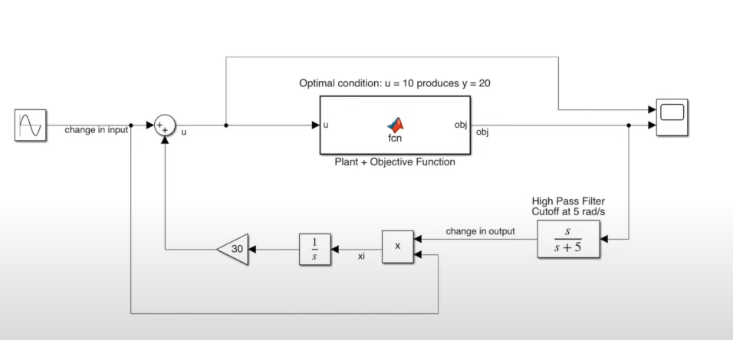

In [2]:
!pip install numpy scipy plotly nbformat

In [3]:
import numpy as np
from scipy.signal import butter, lfilter


def extremum_seeking_control(plant, 
                             initial_input, 
                             sine_wave_amplitude, 
                             sine_wave_frequency, 
                             high_pass_cutoff_frequency, 
                             gain, 
                             steps, 
                             dt):
    """
    Implement an extremum seeking control algorithm to find the maximum of a black-box function.
    
    Parameters:
    ----------
    plant (function)                    : The black-box function to optimize.
    initial_input (float)               : The starting input value to the plant.
    sine_wave_amplitude (float)         : The amplitude of the sine wave perturbation.
    sine_wave_frequency (float)         : The frequency of the sine wave perturbation.
    high_pass_cutoff_frequency (float)  : The cutoff frequency of the high-pass filter.
    gain (float)                        : The gain of the control adjustment.
    steps (int)                         : The number of time steps to simulate.
    dt (float)                          : The time step size.
    
    Returns:
    -------
    u, y (tuple)                        : Two numpy arrays containing the input and output values at each time step.
    """
    
    # Initialize the input and output arrays
    u = np.zeros(steps)
    y = np.zeros(steps)
    hp_y = np.zeros(steps)
    multiply_y = np.zeros(steps)
    integral_y = np.zeros(steps)
    gain_y = np.zeros(steps)
    u[0] = initial_input
    
    # Create the high-pass filter
    b, a = butter(1, high_pass_cutoff_frequency * dt, btype='high', analog=False)
    
    # Simulate the extremum seeking control loop
    for i in range(1, steps):
        
        # Add the sine wave perturbation to the input
        perturbation = sine_wave_amplitude * np.sin(sine_wave_frequency * i * dt)
        u_perturbed = u[i-1] + perturbation
        
        # Compute the output of the plant with perturbed input
        y[i] = plant(u_perturbed)

        # Apply the high-pass filter to the output
        y_filtered = lfilter(b, a, y[:i+1])
        hp_y[i] =y_filtered[-1]

        # Multiply the perturbed input signal and the filtered output signal
        product = perturbation * y_filtered[-1]
        multiply_y[i] = product

        # Integrate the product and apply the gain
        integral = np.sum(product) * dt
        control_adjustment = gain * integral
        integral_y[i] = integral
        gain_y[i] = control_adjustment
        
        # Update the input value
        u[i] = u[i-1] + control_adjustment

    return u, y, hp_y, multiply_y, integral_y, gain_y


In [4]:
# Define a sample plant function
def plant(input_value):
    """
    A sample plant function for testing the extremum seeking control.
    
    Parameters:
    ----------
    input_value (float)  : The input value to the plant.
    
    Returns:
    -------
    plant_output (float) : The output value of the plant.
    """

    plant_output = 20 - (0.2 * (10 - input_value)**2)
    return plant_output

In [5]:
# Set parameters for the extremum seeking control
initial_input = 0
sine_wave_amplitude = 0.3
sine_wave_frequency = 30
high_pass_cutoff_frequency = 5
gain = 30
steps = 1000
dt = 0.01

# Run the extremum seeking control
u, y, hp_y, multiply_y, integral_y, gain_y = extremum_seeking_control(plant, 
                                                                      initial_input, 
                                                                      sine_wave_amplitude, 
                                                                      sine_wave_frequency, 
                                                                      high_pass_cutoff_frequency, 
                                                                      gain, 
                                                                      steps, 
                                                                      dt)

# Print the results
print("Optimal input:", u[-1])
print("Optimal output:", y[-1])

Optimal input: 9.874503504915003
Optimal output: 19.966069903274555


In [6]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=2, cols=2, shared_xaxes=True, subplot_titles=("1. High Pass Filter Output", "2. Multiplied Output", "3. Integration Output", "4. Gain Output"))

fig.append_trace(go.Scatter(
    x=np.arange(steps)*dt,  # Time axis
    y=hp_y,
    mode='lines',
    name='1. High Pass Filter Output'
), row=1, col=1)

fig.append_trace(go.Scatter(
    x=np.arange(steps)*dt,  # Time axis
    y=multiply_y,
    mode='lines',
    name='2. Multiplied Output'
), row=1, col=2)

fig.append_trace(go.Scatter(
    x=np.arange(steps)*dt,  # Time axis
    y=integral_y,
    mode='lines',
    name='3. Integration Output'
), row=2, col=1)

fig.append_trace(go.Scatter(
    x=np.arange(steps)*dt,  # Time axis
    y=gain_y,
    mode='lines',
    name='4. Gain Output'
), row=2, col=2)

# Match x axes
fig.update_xaxes(matches='x')

# remove the margins
fig.update(
    layout=go.Layout(
        margin=go.layout.Margin(l=0.5, r=0.5, b=0.5, t=50),
    )
)

fig.show()

In [7]:
import plotly.graph_objects as go

# Create a figure
fig = go.Figure()

# Add a trace for u
fig.add_trace(go.Scatter(
    x=np.arange(steps)*dt,  # Time axis
    y=u,
    mode='lines',
    name='Control Input'
))

# Add a trace for y
fig.add_trace(go.Scatter(
    x=np.arange(steps)*dt,  # Time axis
    y=y,
    mode='lines',
    name='Plant Output'
))

# Set the title and labels
fig.update_layout(
    title='Extremum Seeking Control Simulation',
    xaxis_title='Time (s)',
    yaxis_title='Value',
    margin=go.layout.Margin(l=0.5, r=0.5, b=0.5, t=50),
    hovermode = "x unified",
    legend_traceorder="normal"
)

# Show the figure
fig.show()